In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import seaborn as sns
from scipy.stats import norm, ks_2samp
from statsmodels.stats.power import tt_ind_solve_power as power


In [2]:
# This helper function creates Matplotlib figures for the
# histograms used in this document.
def hist_helper(ax, x_label, y_label):
    ax.set_ylim(0,.0025)
    ax.set_xlim(0,1500)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12) 
    return ax

In [219]:
# This function reduces scores with the outcome False: 
# When a player loses the game, there score must be 0.
# Also turns the pandas df into a np array
def reduce(file_name):
    df = pd.read_csv(f'../data/{file_name}.csv')
    df.score.where(df.outcome,0,inplace=True)
    return np.array(df.score)

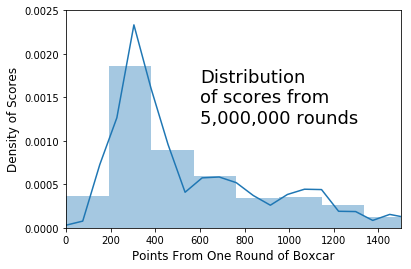

In [4]:
# This cell creates a histogram showing the
# distribution of points from 5 million rounds
# of boxcar using the Perfect VP.
fig, ax = plt.subplots()
df = pd.read_csv('../data/boxcar.csv')
ax = sns.distplot(df['score'])
ax = hist_helper(ax,
                 'Points From One Round of Boxcar',
                 'Density of Scores') 
ax.text(600, .0012, 'Distribution\nof scores from\n5,000,000 rounds', fontsize=18 )
plt.savefig('../images/sim_size_test.png', format='png')
plt.show()
plt.close()

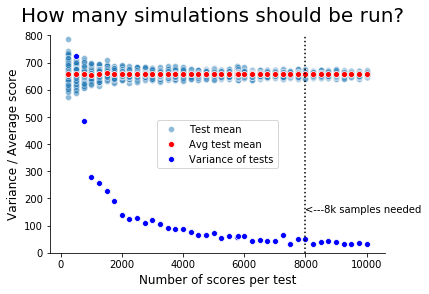

In [5]:
# This cell creates a scatter plot showing how
# big the simulation sample size should be.
fig, ax = plt.subplots()
df = pd.read_csv('../data/batchtestold.csv')
mean = df.groupby('batch_size').mean()
std = df.groupby('batch_size').var()
ax = sns.scatterplot(df['batch_size'], 
                     df['mean'], 
                     alpha=.5,
                     label='Test mean')
ax = sns.scatterplot(mean['mean'].index,
                     mean['mean'],
                     color = 'r',
                     label='Avg test mean')
ax = sns.scatterplot(std['mean'].index,
                     std['mean'],
                     color='b',
                     label='Variance of tests')
ax.set_xlabel('Number of scores per test', fontsize=12)
ax.set_ylabel('Variance / Average score', fontsize=12) 
plt.ylim(bottom=0, top=800);
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.suptitle('How many simulations should be run?', fontsize=20)
ax.axvline(8000, color='k', linestyle=':')
ax.text(8000,150, '<---8k samples needed')
plt.legend()
plt.show()
plt.savefig('../images/sim_size_test.png', format='png')
plt.close()

''

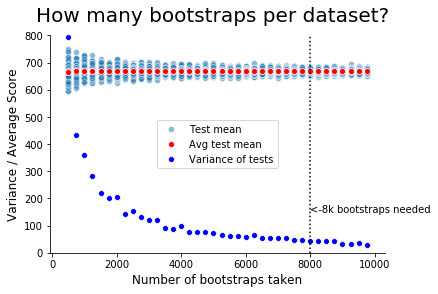

In [16]:
scores = pd.read_csv('../data/boottests.csv')
grp_mean = scores.groupby('size')['mean'].mean()
grp_var = scores.groupby('size')['mean'].var()
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax = sns.scatterplot(scores['size'],
                     scores['mean'],
                     alpha=.5,
                     label='Test mean')
ax = sns.scatterplot(grp_mean.index,
                     grp_mean,
                     color ='r',
                     label='Avg test mean')
ax = sns.scatterplot(grp_var.index,
                     grp_var,
                     color ='b',
                     label='Variance of tests')
plt.ylim(bottom=0, top=800);
plt.legend()
ax.set_ylabel('Variance / Average Score', fontsize=12)
ax.set_xlabel('Number of bootstraps taken', fontsize=12)
fig.suptitle('How many bootstraps per dataset?', fontsize=20)
ax.axvline(8000, color='k', linestyle=':')
ax.text(8000,150, '<-8k bootstraps needed')
plt.savefig('../images/boot_size_test.png', format='png')
;

In [227]:
def get_dist(array):
    mean = []
    std = []
    for _ in range(8000):
        boot = np.random.choice(a=array,size=8000,replace=True)
        mean.append(boot.mean())
        std.append(boot.std())
    return norm(np.mean(mean), (np.mean(std)/np.sqrt(8000)) )


In [230]:
def dist_plot(ax, tup, x):
    if tup[3]:
        df = reduce(tup[0])
    else:
        df = np.array(pd.read_csv(tup[0]).score)
    ax.plot(x,get_dist(df).pdf(x),linewidth=2,label=tup[1])
    ax.axvline(df.mean(),color=tup[2],linestyle=':')

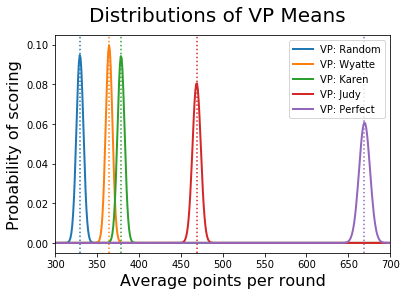

In [231]:
fig, ax = plt.subplots()
x = np.linspace(0, 2000, num=2000)
for tup in [('random','VP: Random','C0', True),
            ('wyatte', 'VP: Wyatte', 'C1', True),
            ('karen', 'VP: Karen', 'C2', True),
            ('judy', 'VP: Judy', 'C3', True),
            ('../data/perfect.csv', 'VP: Perfect', 'C4', False)]:
    dist_plot(ax, tup, x)
ax.set_xlim(300,700)
ax.legend()
ax.set_ylabel('Probability of scoring', fontsize=16)
ax.set_xlabel('Average points per round', fontsize=16)
fig.suptitle('Distributions of VP Means', fontsize=20)
plt.savefig('../images/vp_compare.png', format='png')
plt.show()
plt.close()

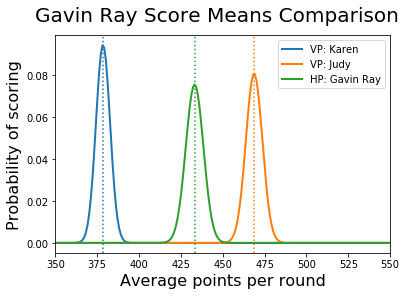

In [232]:
fig, ax = plt.subplots()
x = np.linspace(0, 2000, num=2000)
for tup in [('karen', 'VP: Karen', 'C0', True),
            ('judy', 'VP: Judy', 'C1', True),
            ('GavinRay', 'HP: Gavin Ray', 'C2', True)]:
    dist_plot(ax, tup, x)
ax.set_xlim(350,550)
ax.legend()
ax.set_ylabel('Probability of scoring', fontsize=16)
ax.set_xlabel('Average points per round', fontsize=16)
fig.suptitle('Gavin Ray Score Means Comparison', fontsize=20)
plt.savefig('../images/hp_compare.png', format='png')
plt.show()
plt.close()

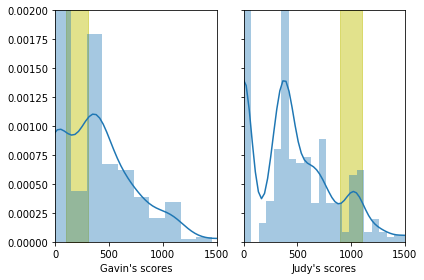

In [220]:
import matplotlib.patches as patches
plt.close()
null =reduce('GavinRay')
alt = reduce('judy')
# Plotting scores from GavinRay.csv and judy.csv as histograms.
fig, axes = plt.subplots(1,2)
sns.distplot(null, ax=axes[0])
sns.distplot(alt, ax=axes[1])
axes[0].fill_between([100, 300], [.002,.002], color='y', alpha=.45)
axes[1].fill_between([900, 1100], [.002,.002], color='y', alpha=.45)
axes[0].set_ylim(0,.002)
axes[0].set_xlim(0,1500)
axes[0].set_xlabel('Gavin\'s scores')
axes[1].set_ylim(0,.002)
axes[1].set_xlim(0,1500)
axes[1].set_xlabel('Judy\'s scores')
axes[1].set_yticklabels([])
fig.tight_layout()
plt.savefig('../images/hp_jd_compare.png', format='png')
plt.show()
plt.close()

These two graphs show the differences between our human player's scores and the Judy VP. Mainly, our player is making more scores in the 100 to 300 point range as indicated by the yellow bar. Judy, on the other hand, is giving up these scores. As a result, Judy is able to gain substantially more rolls with scores between 900 and  1100.

We will now give our human player a second try after informing them of these new revelations.

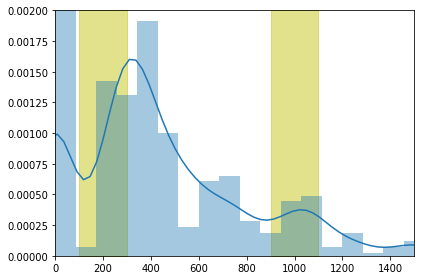

In [223]:
h2 = reduce('GavinRay2')
fig, ax = plt.subplots()
sns.distplot(h2, ax=ax)
ax.set_ylim(0,.0015)
ax.set_xlim(0,1500)
ax.fill_between([100, 300], [.002,.002], color='y', alpha=.45)
ax.fill_between([900, 1100], [.002,.002], color='y', alpha=.45)
ax.set_ylim(0,.002)
ax.set_xlim(0,1500)
fig.tight_layout()
plt.savefig('../images/hp2_compare.png', format='png')
plt.show()
plt.close()

In [76]:
null_vs_sample_p_score = ks_2samp(h2['score'], null['score'])
alt_vs_sample_p_score = ks_2samp(h2['score'], np.random.choice(alt['score'],500))
print(null_vs_sample_p_score)
print(alt_vs_sample_p_score)
print(null.mean())
print(h2.mean())

Ks_2sampResult(statistic=0.10599999999999998, pvalue=0.006634750962621394)
Ks_2sampResult(statistic=0.10199999999999998, pvalue=0.010125210232304454)
score      433.2
outcome      0.7
dtype: float64
score      472.000
outcome      0.804
dtype: float64


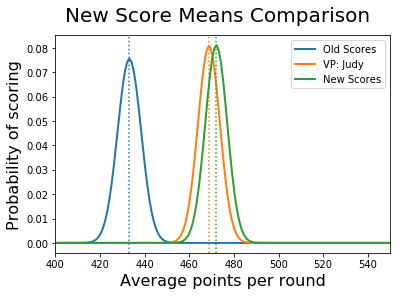

In [233]:
fig, ax = plt.subplots()
x = np.linspace(0, 2000, num=2000)
for tup in [('GavinRay', 'Old Scores', 'C0', True),
            ('judy', 'VP: Judy', 'C1', True),
            ('GavinRay2', 'New Scores', 'C2', True)]:
    dist_plot(ax, tup, x)
ax.set_xlim(400,550)
ax.legend()
ax.set_ylabel('Probability of scoring', fontsize=16)
ax.set_xlabel('Average points per round', fontsize=16)
fig.suptitle('New Score Means Comparison', fontsize=20)
plt.savefig('../images/hp3_compare.png', format='png')
plt.show()
plt.close()